In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from time import time
import pydaptivefiltering as pdf

In [2]:
# --- SETUP DA SIMULAÇÃO ---
np.random.seed(42)
n_samples = 2000

# 1. Sistema Desconhecido (Planta IIR)
# H(z) = (1.0 + 0.5z^-1) / (1 - 0.8z^-1 + 0.15z^-2)
b_true = np.array([1.0, 0.5])
a_true_vals = np.array([0.8, -0.15]) # Representando -a1 e -a2

zeros_order = len(b_true) - 1
poles_order = len(a_true_vals)

# 2. Gerar Sinais
x = np.random.randn(n_samples) # Entrada: Ruído Branco
# Planta real
d_clean = signal.lfilter(b_true, np.insert(-a_true_vals, 0, 1.0), x)
# Adicionando ruído de medição (SNR moderado)
d = d_clean + 0.05 * np.random.randn(n_samples)

In [3]:
# --- INICIALIZAÇÃO DO FILTRO ---
# alpha: fator de esquecimento (0.05 é agressivo, típico para GN)
# step_size: 1.0 é o padrão para Gauss-Newton (Newton Step)
gn_filter = pdf.GaussNewton(
    zeros_order=zeros_order,
    poles_order=poles_order,
    alpha=0.02,
    step_size=0.1,
    delta=1e-4
)

# --- EXECUÇÃO ---
result = gn_filter.optimize(
    input_signal=x, 
    desired_signal=d, 
    verbose=True, 
    return_internal_states=True
)

[GaussNewton] Completed in 64.04 ms


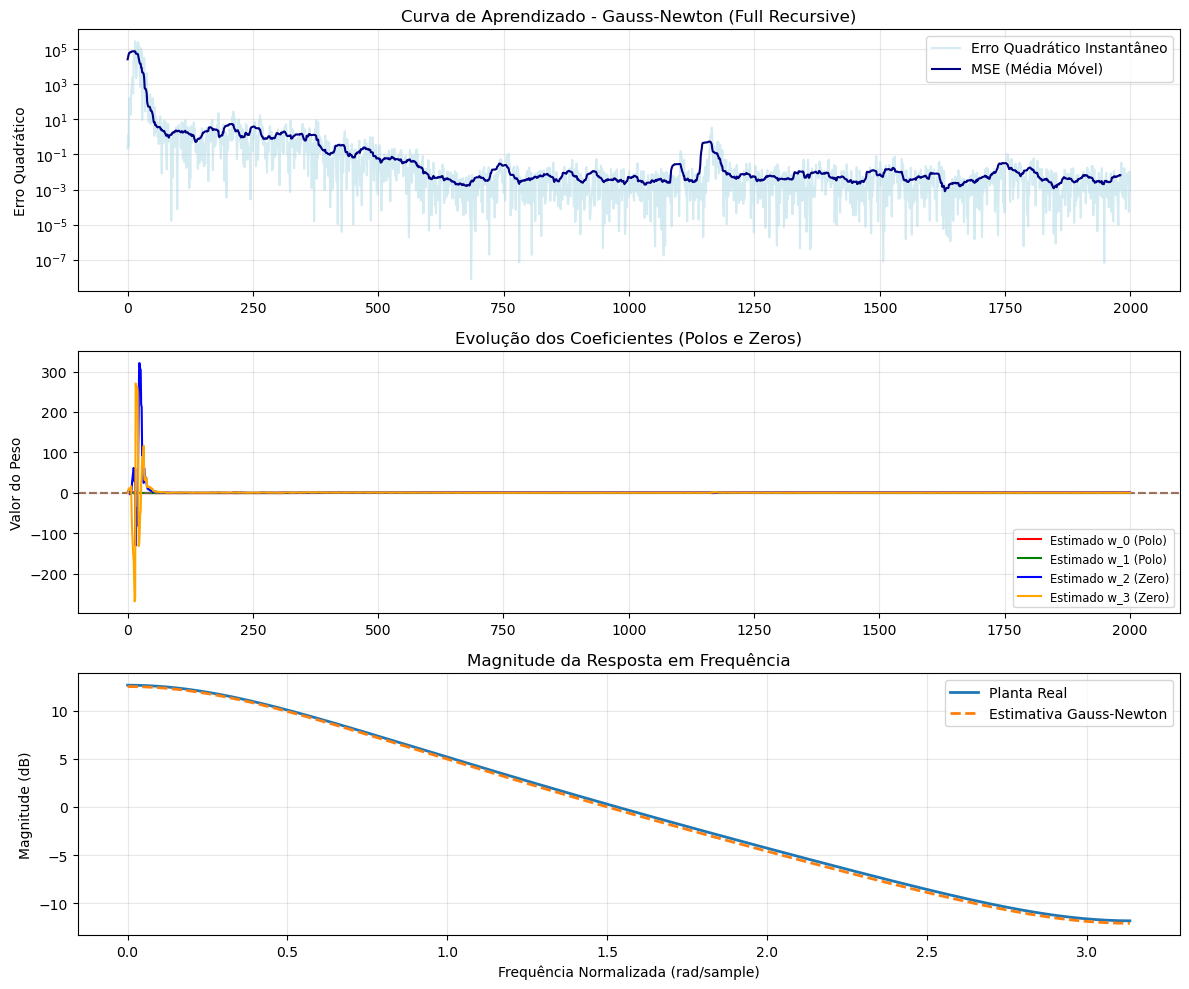

Pesos Reais: [ 0.8  -0.15  1.    0.5 ]
Pesos Finais: [ 0.81491974 -0.1593695   0.97172917  0.4803719 ]


In [4]:
# --- ANÁLISE DE PERFORMANCE ---
plt.figure(figsize=(12, 10))

# 1. Curva de Aprendizado (MSE)
plt.subplot(3, 1, 1)
plt.semilogy(result.errors**2, label='Erro Quadrático Instantâneo', color='lightblue', alpha=0.5)
# Média móvel para suavizar
mse_smooth = np.convolve(result.errors**2, np.ones(20)/20, mode='valid')
plt.semilogy(mse_smooth, label='MSE (Média Móvel)', color='navy')
plt.title('Curva de Aprendizado - Gauss-Newton (Full Recursive)')
plt.ylabel('Erro Quadrático')
plt.grid(True, which="both", alpha=0.3)
plt.legend()

# 2. Convergência dos Parâmetros
plt.subplot(3, 1, 2)
w_hist = np.array(result.coefficients)
colors = ['r', 'g', 'b', 'orange']
for i in range(gn_filter.n_coeffs):
    label_str = f'w_{i} (Polo)' if i < poles_order else f'w_{i} (Zero)'
    plt.plot(w_hist[:, i], label=f'Estimado {label_str}', color=colors[i % len(colors)])
    
    # Linhas de referência reais
    ref_val = a_true_vals[i] if i < poles_order else b_true[i - poles_order]
    plt.axhline(y=ref_val, color=colors[i % len(colors)], linestyle='--', alpha=0.4)

plt.title('Evolução dos Coeficientes (Polos e Zeros)')
plt.ylabel('Valor do Peso')
plt.legend(loc='lower right', fontsize='small')
plt.grid(True, alpha=0.3)

# 3. Comparação Final de Resposta em Frequência
plt.subplot(3, 1, 3)
w_final = gn_filter.w
a_est = w_final[:poles_order]
b_est = w_final[poles_order:]

w_freq, h_true = signal.freqz(b_true, np.insert(-a_true_vals, 0, 1.0))
_, h_est = signal.freqz(b_est, np.insert(-a_est, 0, 1.0))

plt.plot(w_freq, 20 * np.log10(np.abs(h_true)), label='Planta Real', linewidth=2)
plt.plot(w_freq, 20 * np.log10(np.abs(h_est)), '--', label='Estimativa Gauss-Newton', linewidth=2)
plt.title('Magnitude da Resposta em Frequência')
plt.xlabel('Frequência Normalizada (rad/sample)')
plt.ylabel('Magnitude (dB)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Pesos Reais: {np.concatenate((a_true_vals, b_true))}")
print(f"Pesos Finais: {gn_filter.w}")